<a href="https://colab.research.google.com/github/aquapathos/BasicAI/blob/master/5CNN/CIFAR10PyTorch001.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<font color=red>ランタイムメニューで「ランタイムのタイプを変更」を開き、「ハードウェアアクセラレータ」が**GPU**となっていることを確認してください。なっていないなら**GPU**に切り替え、次のセルを実行してください。</font>

次のセルを実行してください（▶マークをクリックするか、Shift＋Enter）



In [1]:
#@title
import datetime
print(datetime.datetime.now())

# 動作環境の確認
import torch,os
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

if device.type == 'cpu':
  print('このランタイムはCPUのみです。GPUによる機械学習の高速化は利用できません。')
  batch_size = 4 # バッチサイズ　データ数いくつごとにモデル修正するか
  EPOCH = 2 # エポック（＝全データをモデル修正に１回ずつ使う）を２回繰り返す
  EXTEPOCH = 3 # model3 の追加学習
  workers = 2 # 並列処理するときの並列実行の数
  N_MID=32 # model3 の後半の畳み込み層のノード数
else:
  print(f'このランタイムはGPU {torch.cuda.get_device_name()}が利用可能です。')
  os.environ['CUDA_LAUNCH_BLOCKING'] = "1"   # device side error が出る場合があるので同期を有効にしておく。（デバッグ用）
  batch_size = 8 # バッチサイズ　データ数いくつごとにモデル修正するか
  EPOCH = 5 # エポック（＝全データをモデル修正に５回ずつ使う）を５回繰り返す
  EXTEPOCH=10 # model3 の追加学習
  workers = 1 # 並列処理するときの並列実行の数
  N_MID=64 # model3 の後半畳み込み層のノード数

2022-11-16 04:02:34.705484
このランタイムはGPU Tesla T4が利用可能です。


# CIFAR-10 にチャレンジ
(参考）[CIFAR-10データセットの日本語による解説](https://atmarkit.itmedia.co.jp/ait/articles/2006/10/news021.html)

## CIFAR-10

![](https://pytorch.org/tutorials/_images/cifar10.png)

CIFAR-10 はAlex Krizhevsky, Vinod Nair, Geoffrey Hinton によって収集された画像データセットで、画像認識のための機械学習の研究や学習でよく取り上げられます。

このデータセットに集められている画像は、縦32×横32ピクセルという小さいカラー画像で、容量の小さいPCでも扱えるのが特徴です。

CIFAR-10 には訓練用50000枚、テスト用10000枚、計60000枚の画像が含まれており、
- airplane (飛行機)
- automobile (自動車）
- bird (鳥類）
- cat （ネコ)
- deer (シカ）
- dog （イヌ）
- frog （カエル）
- horse（ウマ）
- ship（船舶）
- truck（トラック） 

のいずれかのラベルがつけられています。



# １．データの読み込みと確認
　<font color=blue>次のセルを実行してください</font>　コードは非表示にしてありますが、必ず実行してください。

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


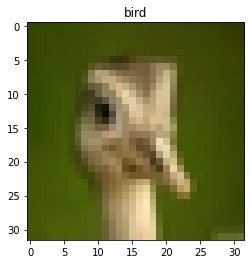

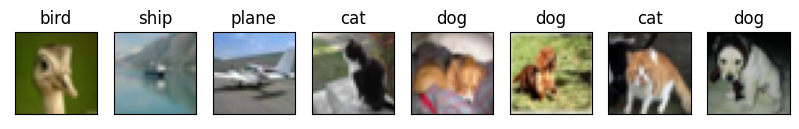

In [2]:
#@title  CIFAR10データセットの読み込み
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter
import numpy as np
import matplotlib.pyplot as plt
import os

TESTEPOCH = 1 # 動作確認のためのエポック数

classesC10 = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# データ変換の定義　範囲[-1,+1]のテンソル表現への変換
transform0 = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# CIFAR10の訓練用データとデータローダ
trainsetC10 = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform = transform0)
trainloaderC10 = torch.utils.data.DataLoader(trainsetC10, batch_size=batch_size,
                                          shuffle=True, num_workers=workers)
# CIFAR10のテスト用データとデータローダ
testsetC10 = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform = transform0)
testloaderC10 = torch.utils.data.DataLoader(testsetC10, batch_size=batch_size,
                                          shuffle=True, num_workers=workers)

# 画像を１枚表示する関数
def t2np(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    return np.transpose(npimg, (1, 2, 0))

# データローダからバッチ数分の画像を取り出す。
dataiter = iter(trainloaderC10)
images, labels = dataiter.next()

# 先頭の画像を表示
plt.title("%s" % classesC10[labels[0]])
plt.imshow(t2np(images[0]))

# １バッチ分の画像を並べて表示
def plotchr(images,labels,tlabels=[]):
    # sns.set_context("talk")   # "talk" はタイトルの文字サイズ。　paper <  notebook <  talk <  poster の順にフォントサイズが大きくなる
    low = (len(images)-1)//batch_size+1
    for i,(image,label) in enumerate(zip(images,labels)):
        clabel = classesC10[label]
        image = t2np(image)
        plt.subplot(1,batch_size,i+1)
        plt.xticks([])
        plt.yticks([])
        if len(tlabels) > 0:
          plt.title(f"{clabel}/{classesC10[tlabels[i]]}") 
        else:
          plt.title("%s" % clabel) 
        plt.imshow(image,cmap=plt.cm.gray_r)
plt.figure(figsize=(10,4),dpi=100)
plotchr(images,labels,tlabels=[])

# ２．ヘルパー関数の定義
　<font color=blue>次のセルを実行してください。</font>　　コードは非表示にしてあります

In [8]:
#@title  ヘルパー関数の定義 train,, recognitionResult 
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter(log_dir="./logs")

# 学習ヘルパー関数
# 学習の実行
def train(model, dataloader, optimizer, criterion, epochs=EPOCH,lastepoch=0,label="loss"):
    for epoch in range(lastepoch,epochs,1):  # 全データをEPOCH回学習に利用したら終わり
        running_loss = 0.0
        accuracy = 0
        total = 0
        r_total = 0
        for i, data in enumerate(dataloader, 0):
            # データセットからバッチサイズ個分のデータ[inputs, labels]を取り出す。
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)

            # すべての学習対象パラメータ（結合重み、しきい値）の微係数を０にセット
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(images) # 現モデルを使って出力を求める (forward)
            predicted = torch.max(model(images),1)[1]
            loss = criterion(outputs, labels) # 誤差を計算
            loss.backward() # パラメータを変数として誤差を偏微分(backward)
            optimizer.step() # 誤差逆伝搬学習　誤差が減る方向にパラメータを修正 (optimize) 

            # 統計量の出力
            running_loss += loss.item()
            accuracy += (predicted == labels).sum().item() # 正解数を積算
            total += labels.size(0) # 入力画像数を積算
            r_total += labels.size(0) # 入力画像数の積算、1000バッチ区切りで０リセット
            if i % 100 == 99:
                ndata = len(dataloader.dataset)
                writer.add_scalar(label+"loss", running_loss/r_total,epoch*ndata+total)
                writer.add_scalar(label+"acc", accuracy/r_total,epoch*ndata+total)
            if i % 1000 == 999:    # 1000 バッチごとに表示
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss /r_total:.3f}  acc:{accuracy/r_total:.3f}  ({accuracy}/{r_total})')
                running_loss = 0.0
                accuracy = 0
                r_total = 0

    print('学習完了')

# 結果分析用ヘルパー関数
from pandas.compat.numpy import np_datetime64_compat
import pandas as pd
# クロス集計
def recognitionResult(model, dataloader, classes=[]):
    ndata = 0 #
    NCAT = len(classes) 
    ct1 = np.zeros((NCAT,NCAT),np.uint16) # 認識結果集計表
    for data in dataloader:
      images, labels = data
      ndata += len(images)
      # バッチごとに出力を求める
      images = images.to(device)
      outputs = torch.max(model(images),1)[1]
      for i in range(len(labels)):
        ct1[labels[i],outputs[i]] += 1
    crossT1 = pd.concat([pd.DataFrame(classes,columns=['正解カテゴリ']),pd.DataFrame(ct1,columns=classes)],axis=1)
    #crossT1 = pd.concat([crossT1,pd.DataFrame([np.round(1000*crossT1[cat][i]/ndata*NCAT)/10 for i,cat in enumerate(classes)],columns=['正解率'])],axis=1).set_index('正解カテゴリ')
    crossT1 = pd.concat([crossT1,pd.DataFrame([np.nan if sum(ct1[i])==0 else np.round(1000*crossT1[cat][i]/np.sum(ct1[i]))/10 for i,cat in enumerate(classes)],columns=['正解率'])],axis=1).set_index('正解カテゴリ')
    ccount = 0
    for i in range(len(classes)):
      ccount += ct1[i,i]
    print(f"正解率は{np.round(1000*ccount/ct1.sum())/10}%")
    return crossT1


# ３．モデル定義


![models0](https://user-images.githubusercontent.com/5820803/184133695-65687a01-f4b8-469f-ada9-016926254d73.png)

次の3つのモデルで機械学習と認識を試してみます。  
1. model1 ３層の全結合層からなるバックプロパゲーションネットワーク
2. model2 基本的なCNN（畳み込みニューラルネットワーク）
3. model3 全結合層をGAP(グローバルアベレージプーリング）層で置き換えたCNN

## (1) model1 ３層全結合モデル
入力層は3072ノード、中間層16ノード、出力層10ノードとします。
入力画像は32✕32画素で各画素がRGBの３成分を持ち、32×32✕3＝3072バイトで表されますので、1つの画素の１つの色成分を１つのニューロンに対応付けます。

出力の表現としては、出力とカテゴリを１：１に対応付けるワンホットエンコーディングを採用し、10ノードとします。  
　
中間層は16としていますが、16と言う数に根拠はありませんので、この数を変えればもっとよい結果が得られるかもしれません。ぜひチャレンジしてみてください。

## 参考　出力とカテゴリの対応付け方法
##### **数値エンコーディング(numeric encoding)** 
　　各カテゴリに１つの数値を割り当てる。出力ノードは１つでよい。
##### **バイナリエンコーディング(binary encoding)**  
　　各カテゴリに１つの２進表現を割り当てる。出力ノード数は2進表現の桁数。  
##### **ワンホットエンコーディング (one hot encoding)**    
　　カテゴリに１つにノードを１つ対応付ける。出力ノード数はカテゴリ数に一致する。

 >| カテゴリ|数値エンコーディング | バイナリエンコーディング|ワンホットエンコーディング|  
 |:---:|:---:|:---:|:---:|
 |ネコ|0|0 0|1 0 0 0|
 |イヌ|1|0 1|0 1 0 0|  
 |家|2|1 0|0 0 1 0|
 |車|3|1 1|0 0 0 1|
||||

　<font color=blue>次のセルを実行してください</font>  コードは非表示にしてあります



In [9]:
#@title model1
# model1
class Model1(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(3*32*32, 16)  # 3x32x32=3072 -> 10
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(16, 10)  # 3x32x32=3072 -> 10
    def forward(self, x):
        x = torch.flatten(x, 1) #3x32x32
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

model1 = Model1()
model1 = model1.to(device)

criterion1 = nn.CrossEntropyLoss() # カテゴリカルクロスエントロピー
optimizer1 = optim.SGD(model1.parameters(), lr=0.001, momentum=0.9) # SGD（確率的勾配降下法）
#optimizer = optim.Adam(model1.parameters(), lr=0.001) # 

# モデル概要
summary(model1,(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 16]          49,168
              ReLU-2                   [-1, 16]               0
            Linear-3                   [-1, 10]             170
Total params: 49,338
Trainable params: 49,338
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.00
Params size (MB): 0.19
Estimated Total Size (MB): 0.20
----------------------------------------------------------------


**Total paras: 49,338**  
と表示されていることに注目してください。
これは、このニューラルネットワークに約5万の調整可能なパラメータがあることを意味しています。数学的に言うと、このモデルの正解率を最大化するという問題は、５万次元の最適化問題であることを意味します。

## (2) model2  基本的なCNN（畳み込みニューラルネットワーク）

PyTorchの公式サイトの識別器のプログラムのチュートリアル、[TRAINING A CLASSIFIER](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html) に掲載されているモデルです。

畳み込み層が２つ、プーリング層が２つ、全結合層が３つで構成されています。必要最小限の典型的なCNNのモデルと言えるでしょう。

1. 6チャネル、カーネルサイズ５の畳み込み層とプーリング層
2. 16チャネル、カーネルサイズ16の畳み込み層とプーリング層
3. 3層の全結合層　第1中間層のノード数120、第２中間層のノード数84

から成る、最小構成の、典型的な畳み込みニューラルネットワークです。深層学習としてはほぼ最小構成ですが、結構高いパフォーマンスを示します。

このネットワークも、チャネル数、全結合層のノード数は、これが最適であるという根拠はありませんし、実際に最適ではありません。

　<font color=blue>次のセルを実行してください</font> 　<font color=blue>次のセルを実行してください</font>  コードは非表示にしてあります


In [10]:
#@title model2
# PyTorch チュートリアル掲載モデル
class Model2(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.conv1(x) # 3x32x32 -> 6x28x28
        x = self.relu(x)
        x = self.pool(x)  # 6x28x28 -> 6x14x14
        x = self.conv2(x) # 6x14x14 -> 16x10x10
        x = self.relu(x)
        x = self.pool(x)  # 16x10x10 -> 16x5x5
        x = torch.flatten(x, 1) # 16x5x5 -> 400
        # あるいは、x = x.view(-1,400) # 16x5x5 -> 400
        x = self.fc1(x) # 400 -> 120
        x = self.relu(x)
        x = self.fc2(x) # 120 -> 84
        x = self.relu(x)
        x = self.fc3(x) # 84 -> 10
        return x

model2 = Model2()
model2 = model2.to(device)

criterion2 = nn.CrossEntropyLoss() # カテゴリカルクロスエントロピー
optimizer2 = optim.SGD(model2.parameters(), lr=0.001, momentum=0.9) # SGD（確率的勾配降下法）
#optimizer = optim.Adam(model1.parameters(), lr=0.001) # 

# モデル概要
summary(model2,(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             456
              ReLU-2            [-1, 6, 28, 28]               0
         MaxPool2d-3            [-1, 6, 14, 14]               0
            Conv2d-4           [-1, 16, 10, 10]           2,416
              ReLU-5           [-1, 16, 10, 10]               0
         MaxPool2d-6             [-1, 16, 5, 5]               0
            Linear-7                  [-1, 120]          48,120
              ReLU-8                  [-1, 120]               0
            Linear-9                   [-1, 84]          10,164
             ReLU-10                   [-1, 84]               0
           Linear-11                   [-1, 10]             850
Total params: 62,006
Trainable params: 62,006
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/ba

パラメータ数は約６万２千ですが、その大部分は Linear、つまり全結合層のパラメータです。計算量はパラメータ数に比例すると考えられるので、CNNにおいて畳み込み層の計算量は、そのノード数に比して相対的に小さいことがわかります。

## (3) model3  全結合層をGAP(グローバルアベレージプーリング）層で置き換えたCNN

model2 からの変更点は以下の通りです。
- 畳み込み層を２つ増やす。ただし、カーネルサイズを５から３に減らしてある。
- 全結合層をなくし、GAP（Global Average Pooling）に置き換える。
- 畳み込み層のノード数を大きく増やした。6,16 -> 64,128,128,128
- 活性化関数を ReLU からFReLU に変更。
- オプティマイザを SGD から Adam に変更

## 解説
**GAP(Global Average Pooling)**   
１つのチャネル（例えば画像の赤色成分）を、そのチャネルに含まれるノード出力の平均値という１つの値で代表させるという処理を意味します。

**プーリング**というのは、画像をNxN画素ごとに区切って、そのNxN個のノードをそれらの出力の平均値に置き換えていく操作です。その区切りサイズＮを最大限に大きくとって画像サイズに一致させた場合がGAPです。

model2で示したように、CNNでは最後に全結合の層を3～4層設けるのが定番ですが、これをGAPで置き換えてもパフォーマンスは大きく損なわれないということが経験的にわかってきています。

全結合層のパラメータ数は非常に膨大な数になりますが、それをGAPで置き換えるとパラメータ数は数十分の１となり、計算量を大きく削減できます。

<font color=blue>次のセルを実行してください</font>


In [11]:
#@title model3
class FReLU(nn.Module):
    def __init__(self, in_c, k=3, s=1, p=1):
        super().__init__()
        self.f_conv = nn.Conv2d(in_c, in_c, kernel_size=k,stride=s, padding=p,groups=in_c)
        self.bn = nn.BatchNorm2d(in_c)

    def forward(self, x):
        tx = self.bn(self.f_conv(x))
        out = torch.max(x,tx)
        return out

class Model3(nn.Module):
    def __init__(self):
        super().__init__()
        self.n_mid = N_MID
        self.conv1 = nn.Conv2d(3,6, 3,padding=1, padding_mode='replicate') 
        self.frelu = FReLU(6)
        self.conv2 = nn.Conv2d(6,16,3, padding=1,padding_mode='replicate')
        self.frelu1 = FReLU(16)
        self.pool = nn.MaxPool2d(2)  
        self.conv3  = nn.Conv2d(16, self.n_mid, 3, padding=1,padding_mode='replicate')
        self.frelu2 = FReLU(self.n_mid)
        self.conv4  = nn.Conv2d(self.n_mid, self.n_mid, 3,padding=1, padding_mode='replicate')  
        self.frelu3 = FReLU(self.n_mid)    
        self.gavg = nn.AvgPool2d(8) # グローバルアベレージプーリング 
        self.layer = nn.Linear(self.n_mid, 10) 

    def forward(self, x):
        x = self.conv1(x) # 3ch -> 6  3x3フィルタで畳み込み 32x32->32x32
        x = self.frelu(x)
        x = self.conv2(x) # 6ch -> 16  3x3フィルタで畳み込み 32x32 -> 32x32
        x = self.frelu1(x)        
        x = self.pool(x)  # max pooling  2x2  32x32->16x16
        x = self.conv3(x) # 16ch -> n_mid ch 3x3フィルタで畳み込み 16x16 -> 16x16
        x = self.frelu2(x) 
        x = self.conv4(x) # n_mid ch -> n_mid ch 3x3フィルタで畳み込み 16x16 -> 16x16
        x = self.frelu3(x)
        x = self.pool(x)  # max pooling  2x2  16x16->8x8
        x = self.gavg(x)  # n_midノード
        x = x.view(-1,self.n_mid)
        x = self.layer(x) # n_mid->10
        return x


''' # 時間に余裕があるなら、こちらの方がよい結果が得られる
class Model3(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, 3,padding=1, padding_mode='replicate') 
        self.frelu = FReLU(64)
        self.relu = nn.PReLU()
        self.conv2 = nn.Conv2d(64,128,3, padding=1,padding_mode='replicate')
        self.frelu1 = FReLU(128)
        self.pool = nn.MaxPool2d(2)  
        self.conv3  = nn.Conv2d(128, 128, 3, padding=1,padding_mode='replicate')
        self.frelu2 = FReLU(128)
        self.conv4  = nn.Conv2d(128, 128, 3,padding=1, padding_mode='replicate')  
        self.frelu3 = FReLU(128)    
        self.gavg = nn.AvgPool2d(8) # グローバルアベレージプーリング 
        self.layer = nn.Linear(128, 10) 

    def forward(self, x):
        x = self.conv1(x) # 3ch -> 64ch  3x3フィルタで畳み込み 32x32->32x32
        x = self.frelu(x)
        x = self.conv2(x) # 64ch ->128ch  3x3フィルタで畳み込み 32x32 -> 32x32
        x = self.frelu1(x)        
        x = self.pool(x)  # max pooling  2x2  32x32->16x16
        x = self.conv3(x) # 128ch -> 128ch 3x3フィルタで畳み込み 16x16 -> 16x16
        x = self.frelu2(x) 
        x = self.conv4(x) # 128ch -> 128ch 3x3フィルタで畳み込み 16x16 -> 16x16
        x = self.frelu3(x)
        x = self.pool(x)  # max pooling  2x2  16x16->8x8
        x = self.gavg(x)  # 128ノード
        x = x.view(-1,128)
        x = self.layer(x) # 128->10
        return x
'''

model3 = Model3()
model3.to(device)

criterion3 = nn.CrossEntropyLoss() # カテゴリカルクロスエントロピー
#optimizer3 = optim.SGD(model3.parameters(), lr=0.001, momentum=0.9) # SGD（確率的勾配降下法）
optimizer3 = optim.Adam(model3.parameters(), lr=0.001) # 

# モデル概要
summary(model3,(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 32, 32]             168
            Conv2d-2            [-1, 6, 32, 32]              60
       BatchNorm2d-3            [-1, 6, 32, 32]              12
             FReLU-4            [-1, 6, 32, 32]               0
            Conv2d-5           [-1, 16, 32, 32]             880
            Conv2d-6           [-1, 16, 32, 32]             160
       BatchNorm2d-7           [-1, 16, 32, 32]              32
             FReLU-8           [-1, 16, 32, 32]               0
         MaxPool2d-9           [-1, 16, 16, 16]               0
           Conv2d-10           [-1, 64, 16, 16]           9,280
           Conv2d-11           [-1, 64, 16, 16]             640
      BatchNorm2d-12           [-1, 64, 16, 16]             128
            FReLU-13           [-1, 64, 16, 16]               0
           Conv2d-14           [-1, 64,

パラメータ数はおよそ５万（CPUの設定の場合1.6万）です。モデルはmodel1,model2と比べて複雑になっていますが、パラメータ数は大差ありません。


# ４．学習

## (1) model1

#### 動作確認　　<font color=blue>次のセルを実行してください</font> 

In [ ]:
%%time
print("動作確認")
train(model=model1, dataloader=trainloaderC10,optimizer=optimizer1, criterion=criterion1, epochs=TESTEPOCH, label="model1")

**loss** 平均誤差（クロスエントロピー誤差） 
**acc** 正解率　です。    
　<font color=blue>次のセルを実行してください</font>

<font color=red>（注意）学習(train)は２度実行すると追加学習となります。やり直す場合は、モデル定義のセルからやり直してください.</font>

In [ ]:
%%time
train(model=model1, dataloader=trainloaderC10,optimizer=optimizer1,criterion=criterion1, epochs=EPOCH, lastepoch=TESTEPOCH, label="model1")

# model1 正解率 クロス集計

### (model1-1) 訓練データに対する正解率　<font color=blue>次のセルを実行してください</font>

In [ ]:
%%time
trainct1 = recognitionResult(model1,trainloaderC10,classes=classesC10)
trainct1

結果を清書します。<font color=blue>次のセルを実行してください</font>

In [ ]:
trainct1


### (model1-2) テストデータに対する正解率

In [ ]:
%%time
testct1 = recognitionResult(model1,testloaderC10,classes=classesC10)
#testct1

結果を清書します。<font color=blue>次のセルを実行してください</font>

In [ ]:
testct1

正解率は訓練データで4割後半、テストデータで4割前半ぐらいになるはずです。

## (2) model2
　一気に学習させてみましょう。<font color=blue>次のセルを実行してください</font>

In [ ]:
%%time
train(model=model2, dataloader=trainloaderC10,optimizer=optimizer2,criterion=criterion2, epochs=EPOCH, lastepoch=0, label="model2")

# model 2 正解率　クロス集計
### (model2-1) 訓練データに対する正解率　
<font color=blue>次のセルを実行してください</font>

In [ ]:
%%time
trainct2 = recognitionResult(model2,trainloaderC10,classes=classesC10)
#trainct2

結果を清書します。<font color=blue>次のセルを実行してください</font>

In [ ]:
trainct2

### (model2-2) テストデータに対する正解率　　
<font color=blue>次のセルを実行してください</font>

In [ ]:
%%time
testct2 = recognitionResult(model2,testloaderC10,classes=classesC10)
#testct2

結果を清書します。<font color=blue>次のセルを実行してください</font>

In [ ]:
testct2

このモデルでは正解率が訓練用、テスト用ともに６割を超えるぐらいになるはずです。

## (3) model3
<font color=blue>次のセルを実行してください</font>



In [ ]:
%%time
train(model=model3, optimizer=optimizer3, dataloader=trainloaderC10, criterion=criterion3, epochs=EPOCH, lastepoch=0,label="model3")

# model3 正解率　クロス集計
### (model3-1) 訓練データに対する正解率　
<font color=blue>次のセルを実行してください</font>

In [ ]:
%%time
trainct3 = recognitionResult(model3,trainloaderC10,classes=classesC10)
#trainct3

結果を清書します。<font color=blue>次のセルを実行してください</font>

In [ ]:
trainct3

### (model3-2) テストデータに対する正解率　
<font color=blue>次のセルを実行してください</font>


In [ ]:
%%time
testct3 = recognitionResult(model3,testloaderC10,classes=classesC10)
#testct3

結果を清書します。<font color=blue>次のセルを実行してください</font>

In [ ]:
testct3

model3 の正解率は訓練用、テスト用どちらのデータでも8割前後になります。

# <font color=red>学習済みモデルの保存
<font color=red>次の実験に必要となりますので、次のセルを実行して学習済みモデルを保存してください。

これをやらないと、ここまでの実験をもう一度やり直さないといけなくなります。</font>

### 手順１　Google Drive との接続
Google Drive のマウント

1. <font color='blue'>この説明の下のセルを実行する
2. アクセス許可の確認ダイアログが出る。「Googleドライブに接続」をクリック。
3. アカウントを選択する。
4. アクセスリクエストのダイアログに変わる。一番下までスクロールし「許可」をクリック。

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 手順2　Google Drive内に保存
Google Drive 内に学習済みモデルを保存します。　　[次のセルを実行してください]()

In [ ]:
#@title   学習済みモデルの保存
FNAME = 'model3.pth'
DIR = '/content/drive/MyDrive/CIFAR10'  
GPUPATH = f"{DIR}/gpu_{N_MID}_{FNAME}"
CPUPATH = f"{DIR}/cpu_{N_MID}_{FNAME}"
if not os.path.exists(DIR):
  os.makedirs(DIR)
torch.save(model3.to('cpu').state_dict(), CPUPATH)
if device.type == 'cuda':
  torch.save(model3.state_dict(), GPUPATH)
model3 = model3.to(device)

Google Drive の CIFAR10フォルダに
- gpu_XX_model3.pth  - GPUが使える環境用の学習済みモデル
- cpu_XX_model3.pth  - GPUが使えない環境用の学習済みモデル
が保存されます。

XXはGPU環境の場合は64, CPU環境の場合は32です。

In [ ]:
print(datetime.datetime.now())

2022-08-15 10:50:37.835478


# 学習曲線の確認

<font color=blue>次のセルを実行してください</font>

表示には少し時間がかかります。

In [ ]:
# 学習
# Load the TensorBoard notebook extension
%load_ext tensorboard
%tensorboard --logdir logs

<img width="442" alt="5epoch" src="https://user-images.githubusercontent.com/5820803/184563227-7ca463c9-766e-4a8e-8a65-aa48c314af31.png">

loss が０、acc は1が最適（全問正解）を意味します。グラフを見ると model3 は 5 EPOCHは、追加学習でもっとよくなりそうです。ちなみに、1epoch とは、全データをもれなく1度ずつ学習に使うことで、CIFAR-10なら５epochで25万回識別を試みたことになります。

次の演習で model3 を使いますので、<font color=blue>時間があれば、次のセルを実行して、model3 の追加学習を行ってください。</font>

# 追加学習

下のコードを実行すると、model3 をもう5エポック追加学習できます。<font color=red>10分程度時間がかかります。正解率は上がりますが、途中でやめて時間をおいて続きをやるということができませんので、時間に余裕がない場合は、ここで実験を打ち切ってください。</font>


In [ ]:
%%time
model3 = model3.to(device)
train(model=model3, optimizer=optimizer3, dataloader=trainloaderC10, criterion=criterion3, epochs=EXTEPOCH, lastepoch=EPOCH,label="model3")


追加学習した場合は、正解率の改善を確認しましょう

In [ ]:
trainct3 = recognitionResult(model3,trainloaderC10,classes=classesC10)
#trainct3

正解率は82.2%


In [ ]:
trainct3

In [ ]:
testct3 = recognitionResult(model3,testloaderC10,classes=classesC10)
#testct3

正解率は77.0%


In [ ]:
testct3

追加学習を実施した場合は、次のセルを実行して学習済みモデルを更新して下さい。

In [ ]:
if not os.path.exists(DIR):
  os.makedirs(DIR)
torch.save(model3.to('cpu').state_dict(), CPUPATH)
if device.type == 'cuda':
  torch.save(model3.state_dict(), GPUPATH)
model3 = model3.to(device)

以上

In [ ]:
print(datetime.datetime.now())

2022-08-15 10:58:50.604637
